<a href="https://colab.research.google.com/github/sravyagadam/ML_Classification/blob/main/AlmaBetter_ML_Classification_CardioVascularRisk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Balancing Data - Over sampling

In [1]:
!pip install imbalanced-learn >> /dev/null
!pip install smote-variants >> /dev/null
!pip install CatBoost>> /dev/null



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import mglearn
import matplotlib.pyplot as plt 
import smote_variants as sv

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# mount drive and give path of dataset
data = pd.read_csv("/content/drive/MyDrive/cardiovascular_Classification_sravya/data_cardiovascular_risk.csv")

In [ ]:
data.sample(5)

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
3283,3283,50,2.0,F,NO,0.0,0.0,0,0,0,210.0,105.0,77.0,23.96,60.0,86.0,0
1571,1571,55,1.0,M,YES,40.0,0.0,0,0,0,242.0,130.0,85.0,26.79,80.0,93.0,0
302,302,51,3.0,M,YES,20.0,0.0,0,0,0,163.0,126.0,78.0,26.56,63.0,78.0,0
1412,1412,38,NaN,M,NO,0.0,0.0,0,0,0,221.0,119.0,84.0,26.89,66.0,82.0,0
650,650,54,1.0,M,NO,0.0,0.0,0,0,0,206.0,141.0,92.0,35.85,75.0,120.0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3303 non-null   float64
 3   sex              3390 non-null   object 
 4   is_smoking       3390 non-null   object 
 5   cigsPerDay       3368 non-null   float64
 6   BPMeds           3346 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3352 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3376 non-null   float64
 14  heartRate        3389 non-null   float64
 15  glucose          3086 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

In [ ]:
data[["diabetes","glucose"]]

,diabetes,glucose
0,0,80.0
1,0,75.0
2,0,94.0
3,0,94.0
4,0,77.0
...,...,...
3385,0,103.0
3386,0,84.0
3387,0,72.0
3388,0,85.0


In [ ]:
# duplicate
len(data[data.duplicated()])

0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data.isna().sum()

id                   0
age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64

##Dealing with null values

Note: This part is postponed for later stages, now proceeding with deletion of null values.

Missing values in variable "glucose" are 304 in count, deleting them may cause loss of data, so checking correlation between "glucose" and "TenYearCHD"

In [ ]:
# glucose_TenYearCHD_data = data[['glucose','TenYearCHD']]
# correlation_1 = glucose_TenYearCHD_data.corr(method = 'pearson')
# print(correlation_1)

In [ ]:
# data['glucose'].describe()

Deleting rows with Null Values

In [ ]:
data.dropna(inplace=True)

Re-checking null values, if any and new shape of data

In [ ]:
data.isna().sum().sum()

0

In [ ]:
data.shape

(2927, 17)

##Dropping irrelavant variables and duplicates if any.

In [ ]:
data.columns

Index(['id', 'age', 'education', 'sex', 'is_smoking', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')

In [ ]:
data.drop("id", axis=1, inplace=True)
data.drop_duplicates(inplace=True)

In [ ]:
data.shape

(2927, 16)

here shape confirms that there are no duplicates and total columns reduced to 16

In [ ]:
data.describe()

,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000
mean,49.507345,1.965494,9.112743,0.030065,0.006150,0.314315,0.026990,237.129142,132.626409,82.906218,25.797041,75.888282,81.934404,0.151691
std,8.597191,1.017199,11.882784,0.170795,0.078192,0.464322,0.162082,44.613282,22.326197,12.078873,4.130376,11.971207,24.106943,0.358783
min,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,113.000000,83.500000,48.000000,15.960000,45.000000,40.000000,0.000000
25%,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,74.500000,23.030000,68.000000,71.000000,0.000000
50%,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.500000,82.000000,25.380000,75.000000,78.000000,0.000000
75%,56.000000,3.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.000000,90.000000,28.040000,83.000000,87.000000,0.000000
max,70.000000,4.000000,70.000000,1.000000,1.000000,1.000000,1.000000,600.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


In [ ]:
unique, counts = np.unique(data['TenYearCHD'], return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 2483]
 [   1  444]]


It is evident that the dataset is imbalanced as it comprises of very few CHD-Yes(444) cases in comparision to CHD-No(2483) cases. Therfore, we need to balance them before we provide it to our model training.

##Dealing with object type variables 

In [ ]:
data['education'].unique()

array([4., 1., 3., 2.])

In [ ]:
data['sex'].unique()

array(['M', 'F'], dtype=object)

In [ ]:
data['is_smoking'].unique()

array(['NO', 'YES'], dtype=object)

In [ ]:
data = pd.get_dummies(data, drop_first=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 1 to 3389
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              2927 non-null   int64  
 1   education        2927 non-null   float64
 2   cigsPerDay       2927 non-null   float64
 3   BPMeds           2927 non-null   float64
 4   prevalentStroke  2927 non-null   int64  
 5   prevalentHyp     2927 non-null   int64  
 6   diabetes         2927 non-null   int64  
 7   totChol          2927 non-null   float64
 8   sysBP            2927 non-null   float64
 9   diaBP            2927 non-null   float64
 10  BMI              2927 non-null   float64
 11  heartRate        2927 non-null   float64
 12  glucose          2927 non-null   float64
 13  TenYearCHD       2927 non-null   int64  
 14  sex_M            2927 non-null   uint8  
 15  is_smoking_YES   2927 non-null   uint8  
dtypes: float64(9), int64(5), uint8(2)
memory usage: 348.7 KB


our data is now free of object type data

In [ ]:
corr = data.corr()
corr[-3:]

,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,sex_M,is_smoking_YES
TenYearCHD,0.234423,-0.062442,0.059797,0.092868,0.052014,0.169136,0.100006,0.106473,0.217419,0.139005,0.075950,0.018747,0.133286,1.000000,0.081880,0.033342
sex_M,-0.034307,0.033854,0.347277,-0.041431,-0.009121,-0.001199,0.007311,-0.074135,-0.046803,0.052869,0.073776,-0.120345,-0.011242,0.081880,1.000000,0.223871
is_smoking_YES,-0.204398,0.030861,0.775714,-0.042033,-0.051558,-0.123369,-0.050831,-0.047703,-0.148528,-0.131062,-0.165179,0.053532,-0.058830,0.033342,0.223871,1.000000


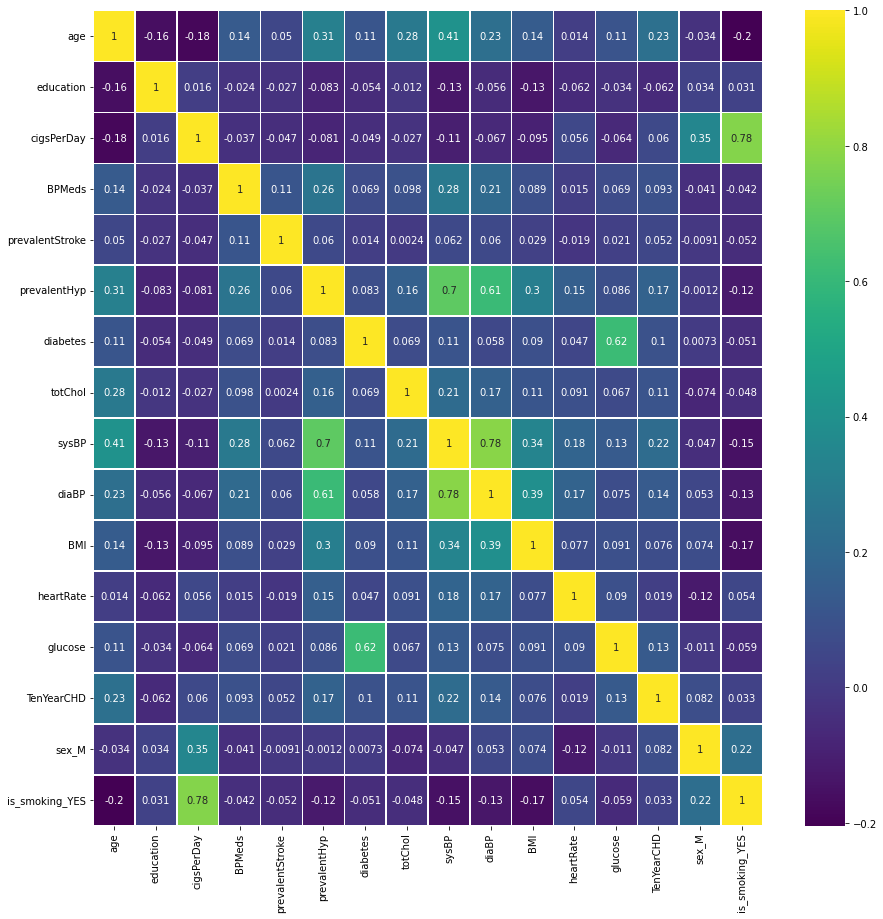

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(), annot=True, cmap='viridis', linewidths=.5)

In [ ]:
unique, counts = np.unique(data['TenYearCHD'], return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 2483]
 [   1  444]]


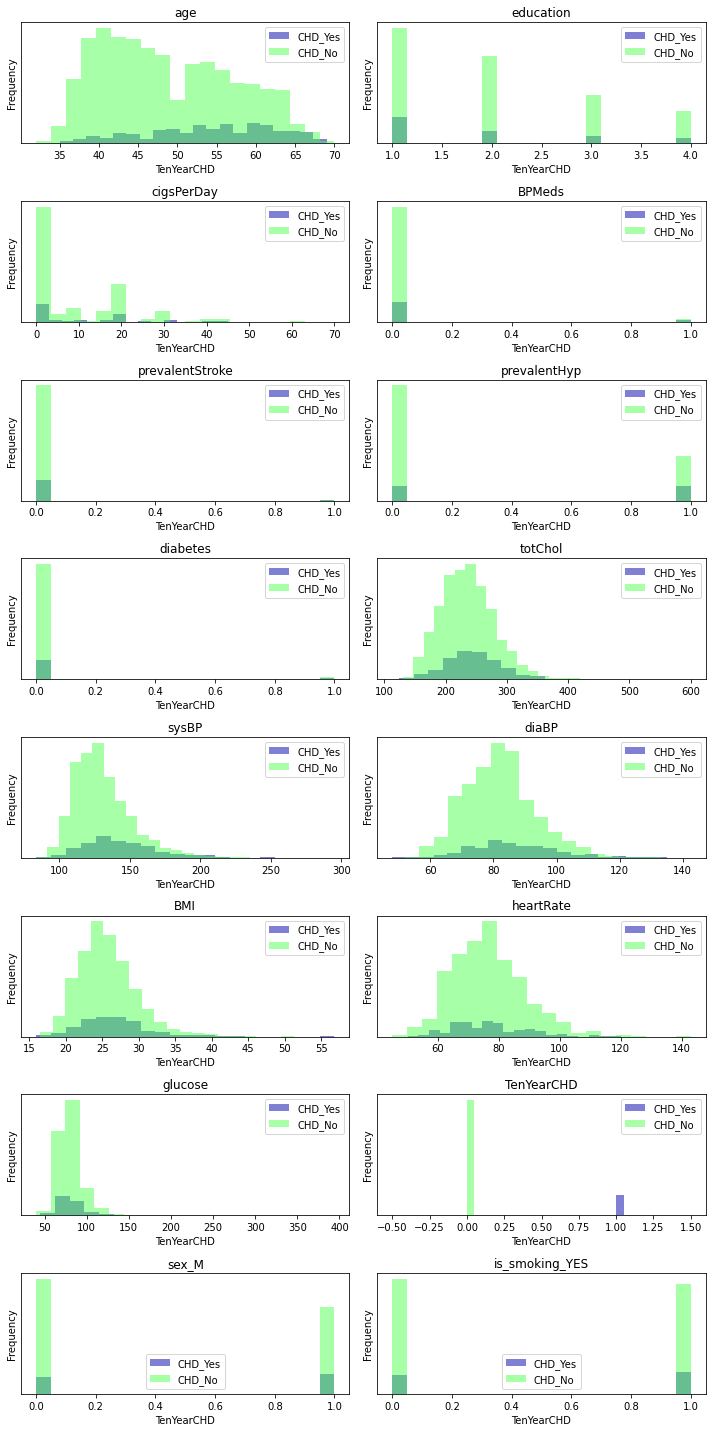

In [ ]:
Risk_Yes =data.loc[data['TenYearCHD']==1]
Risk_No =data.loc[data['TenYearCHD']==0]
fig, axes = plt.subplots(8,2, figsize=(10,20))
ax = axes.ravel()
for i in range(16):
  ax[i].hist(Risk_Yes.iloc[:,i], bins=20, color=mglearn.cm3(0), alpha=.5)
  ax[i].hist(Risk_No.iloc[:,i], bins=20, color=mglearn.cm3(2), alpha=.5)
  ax[i].set_title(list(Risk_Yes)[i])
  ax[i].set_yticks(())
  ax[i].set_xlabel("TenYearCHD")
  ax[i].set_ylabel("Frequency")
  ax[i].legend(["CHD_Yes", "CHD_No"], loc="best")
fig.tight_layout()

There are no characteristics that can be used split the data well

## Data prepation to modeling

In [ ]:
data.sample(5)

,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,sex_M,is_smoking_YES
2847,46,1.0,30.0,0.0,0,0,0,270.0,131.0,81.0,26.40,75.0,83.0,0,1,1
308,48,2.0,0.0,0.0,0,1,0,211.0,149.0,100.0,30.91,78.0,62.0,0,0,0
794,59,1.0,0.0,0.0,0,1,0,288.0,158.0,90.0,32.84,70.0,87.0,0,0,0
2533,52,2.0,0.0,0.0,0,1,0,279.0,148.0,99.0,26.64,86.0,85.0,0,0,0
1161,37,2.0,9.0,0.0,0,0,0,237.0,102.0,72.0,19.68,67.0,83.0,0,1,1


Splitting target variable from independent variables

In [ ]:
target_variable = 'TenYearCHD'
X = data.drop([target_variable], axis=1).values
y = data[target_variable].values

In [ ]:
X

array([[36.,  4.,  0., ..., 75.,  1.,  0.],
       [46.,  1., 10., ..., 94.,  0.,  1.],
       [50.,  1., 20., ..., 94.,  1.,  1.],
       ...,
       [46.,  1.,  0., ..., 84.,  0.,  0.],
       [44.,  3.,  3., ..., 72.,  1.,  1.],
       [54.,  3.,  0., ..., 92.,  0.,  0.]])

In [ ]:
y

array([0, 0, 1, ..., 0, 1, 0])

## Balancing Dataset - MSMOTE


In [ ]:
oversampler= sv.distance_SMOTE()
X_msmote, y_msmote= oversampler.sample(X, y)

2021-12-20 06:48:21,743:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


In [ ]:
unique, counts = np.unique(y_msmote, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 2483]
 [   1 2483]]


Thereby, positive cases are over sampled to resolve 'imbalanced data' issue

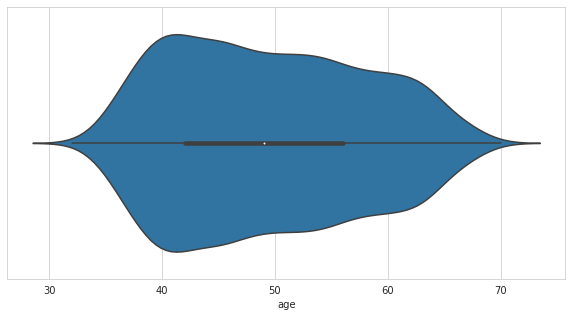

In [ ]:
plt.figure(figsize = (10,5))
ax= sns.violinplot(data['age'])
plt.show()

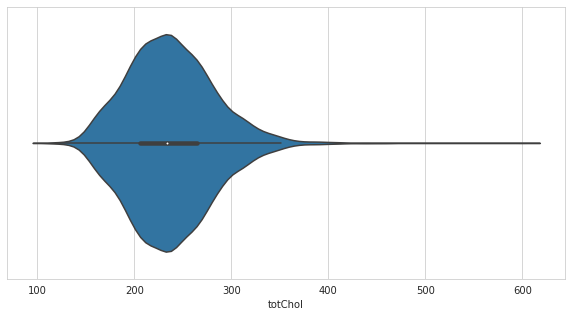

In [ ]:
plt.figure(figsize = (10,5))
ax= sns.violinplot(data['totChol'])
plt.show()

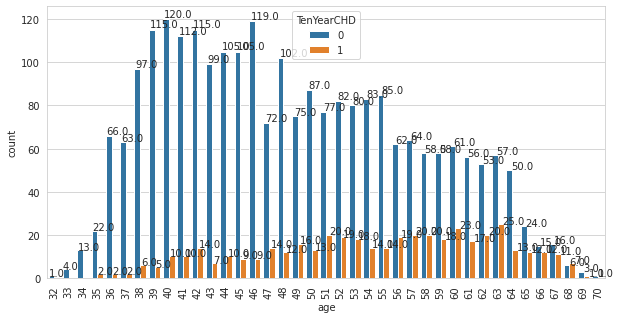

In [ ]:
plt.figure(figsize = (10,5))
ax= sns.countplot(x = "age", hue = "TenYearCHD", data = data)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
plt.xticks(rotation = 90)
plt.show()

High range is in the age gap of 38 to 48 

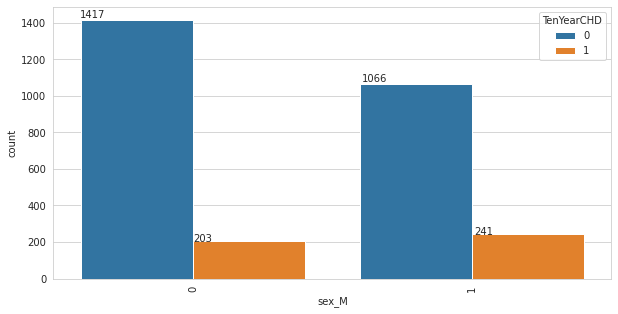

In [ ]:
plt.figure(figsize = (10,5))
ax= sns.countplot(x = "sex_M", hue = "TenYearCHD", data = data)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
plt.xticks(rotation = 90)
plt.show()

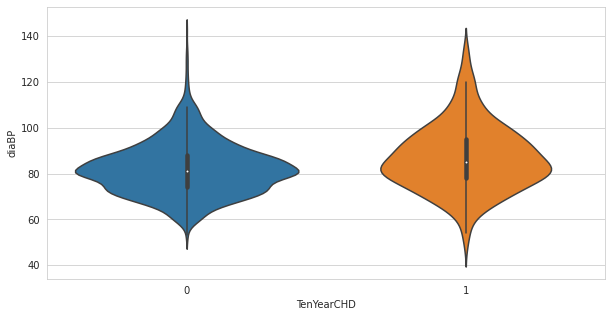

In [ ]:
plt.figure(figsize = (10,5))
sns.violinplot(y = 'diaBP', x = 'TenYearCHD', data = data)
plt.show()

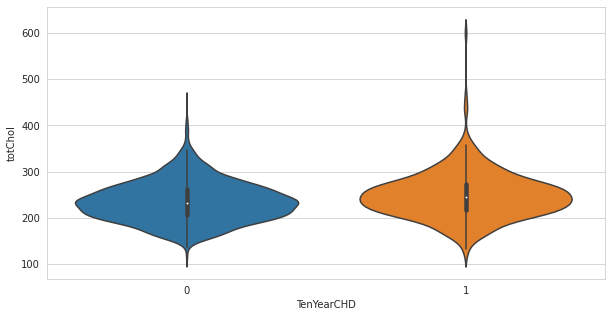

In [ ]:
plt.figure(figsize = (10,5))
sns.violinplot(y = 'totChol', x = 'TenYearCHD', data = data)
plt.show()


##Data Preparation for Modeling

Splitting train and test data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_msmote, y_msmote, test_size=0.2, random_state=0)

In [ ]:
X_train

array([[59.92058386,  1.94859923, 15.        , ..., 81.40657617,
         1.        ,  0.94859923],
       [46.14910939,  1.2836302 ,  0.7563472 , ..., 90.58184899,
         0.2836302 ,  0.1890868 ],
       [63.88158669,  1.32825403,  0.        , ..., 74.67174597,
         0.16412702,  0.        ],
       ...,
       [46.        ,  2.        , 15.        , ..., 86.        ,
         0.        ,  1.        ],
       [68.        ,  1.        ,  0.        , ..., 79.        ,
         1.        ,  0.        ],
       [39.        ,  3.        ,  0.        , ..., 88.        ,
         0.        ,  0.        ]])

In [ ]:
y_train

array([1, 1, 1, ..., 0, 1, 0])

In [ ]:
X_test

array([[42.        ,  3.        ,  0.        , ..., 99.        ,
         0.        ,  0.        ],
       [52.        ,  1.65849685,  0.        , ..., 70.07352838,
         0.88616562,  0.        ],
       [48.        ,  3.        ,  0.        , ..., 82.        ,
         1.        ,  0.        ],
       ...,
       [50.        ,  4.        , 43.        , ..., 74.        ,
         1.        ,  1.        ],
       [46.        ,  3.        , 20.        , ..., 77.        ,
         0.        ,  1.        ],
       [59.        ,  1.        , 10.        , ..., 85.        ,
         0.        ,  1.        ]])

In [ ]:
y_test

array([0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,

Feature Scaling X_train and X_test

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [ ]:
X_train_scaled

array([[ 1.04030652,  0.06056197,  0.4683278 , ..., -0.10765621,
         1.15516018,  0.92852387],
       [-0.65292252, -0.69106849, -0.7772389 , ...,  0.18829801,
        -0.44812231, -0.7088334 ],
       [ 1.52731937, -0.6406291 , -0.8433793 , ..., -0.32489241,
        -0.71557825, -1.11646682],
       ...,
       [-0.6712558 ,  0.11866149,  0.4683278 , ...,  0.04050758,
        -1.08290526,  1.03933368],
       [ 2.03368614, -1.01166251, -0.8433793 , ..., -0.18528184,
         1.15516018, -1.11646682],
       [-1.53191914,  1.24898549, -0.8433793 , ...,  0.10501884,
        -1.08290526, -1.11646682]])

In [ ]:
X_test_scaled

array([[-1.16306343,  1.24898549, -0.8433793 , ...,  0.45983079,
        -1.08290526, -1.11646682],
       [ 0.06645564, -0.26734772, -0.8433793 , ..., -0.47321083,
         0.90039138, -1.11646682],
       [-0.42535199,  1.24898549, -0.8433793 , ..., -0.08851495,
         1.15516018, -1.11646682],
       ...,
       [-0.17944818,  2.37930948,  2.91684774, ..., -0.34656   ,
         1.15516018,  1.03933368],
       [-0.6712558 ,  1.24898549,  0.90556351, ..., -0.24979311,
        -1.08290526,  1.03933368],
       [ 0.92711898, -1.01166251,  0.0310921 , ...,  0.00825195,
        -1.08290526,  1.03933368]])

Here is a data ready to be trained and tested, using any machine learning classification algorithm. 

## Decision Tree Classification

Training the Decision Tree Classification model on the Training set

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

Making the Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tp, tn, fp, fn

(439, 428, 63, 64)

Calculating accuracy score

In [ ]:
accuracy_score_DecisionTree = accuracy_score(y_test, y_pred)
print(accuracy_score_DecisionTree)

0.8722334004024145


In [ ]:
#Cross Validation
cv_results = cross_val_score(classifier, X, y, cv=10) 

print (f"Cross-validated scores {cv_results}")
print(f"The Cross Validation accuracy is: {round(cv_results.mean() * 100,2)}%")

Cross-validated scores [0.75426621 0.76450512 0.80204778 0.75767918 0.80204778 0.76791809
 0.72013652 0.76027397 0.7739726  0.75342466]
The Cross Validation accuracy is: 76.56%


Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       491
           1       0.87      0.87      0.87       503

    accuracy                           0.87       994
   macro avg       0.87      0.87      0.87       994
weighted avg       0.87      0.87      0.87       994



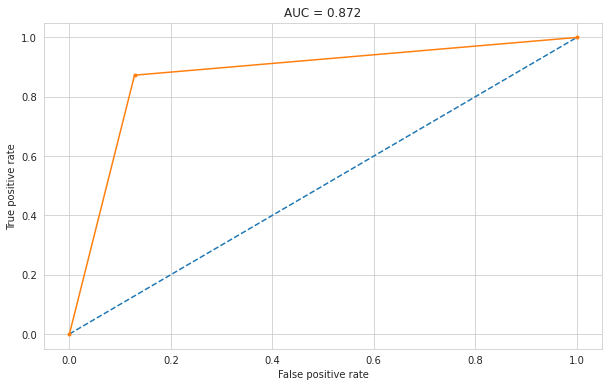

In [ ]:
# ROC curve and AUC 
probs = classifier.predict(X_test_scaled)
# keep probabilities for the positive outcome only
# probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

Hyper parameter tuning

In [ ]:
dt = DecisionTreeClassifier(random_state=42)

In [ ]:
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [ ]:
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [ ]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
CPU times: user 439 ms, sys: 59.8 ms, total: 498 ms
Wall time: 4.59 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [ ]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011981,0.003491,0.000959,0.000057,gini,2,5,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.851964,0.835851,0.850957,0.850957,0.847432,0.006699,37
1,0.015548,0.004004,0.000941,0.000037,gini,2,10,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.851964,0.835851,0.850957,0.850957,0.847432,0.006699,37
2,0.012630,0.005926,0.000899,0.000050,gini,2,20,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.851964,0.835851,0.850957,0.850957,0.847432,0.006699,37
3,0.017043,0.004781,0.001835,0.001600,gini,2,50,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.851964,0.835851,0.850957,0.850957,0.847432,0.006699,37
4,0.020378,0.006701,0.000965,0.000033,gini,2,100,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.851964,0.835851,0.850957,0.850957,0.847432,0.006699,37


In [ ]:
score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
42,0.030880,0.009524,0.000971,0.000027,entropy,10,20,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.894260,0.861027,0.892246,0.877140,0.881168,0.013379,1
47,0.030087,0.003896,0.001024,0.000059,entropy,20,20,"{'criterion': 'entropy', 'max_depth': 20, 'min...",0.894260,0.861027,0.892246,0.877140,0.881168,0.013379,1
17,0.028241,0.008008,0.000981,0.000078,gini,10,20,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.890232,0.875126,0.880161,0.877140,0.880665,0.005807,3
22,0.032284,0.005096,0.004094,0.005251,gini,20,20,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.890232,0.875126,0.880161,0.877140,0.880665,0.005807,3
41,0.055073,0.006332,0.000988,0.000051,entropy,10,10,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.889225,0.864048,0.884189,0.884189,0.880413,0.009669,5


In [ ]:
grid_search.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=20,
                       random_state=42)

In [ ]:
dt_best = grid_search.best_estimator_

In [ ]:
classifier_tuning = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=20,
                       random_state=42)
classifier_tuning.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=20,
                       random_state=42)

In [ ]:
y_pred = classifier_tuning.predict(X_test_scaled)
tn_t, fp_t, fn_t, tp_t = confusion_matrix(y_test, y_pred).ravel()
tp_t,fp_t, fn_t, tp_t

(417, 30, 86, 417)

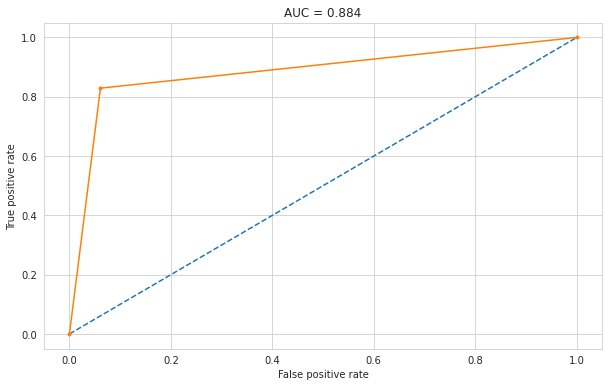

In [ ]:
# ROC curve and AUC 
probs = classifier_tuning.predict(X_test_scaled)
# keep probabilities for the positive outcome only
# probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

##K-Nearest Neighbors (K-NN)

Training the K-NN model on the Training set

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train_scaled, y_train)

KNeighborsClassifier()

Making the Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tp, tn, fp, fn

(475, 373, 118, 28)

Calculating accuracy score

In [ ]:
accuracy_score_KNNClassifier = accuracy_score(y_test, y_pred)
print(accuracy_score_KNNClassifier)

0.8531187122736419


In [ ]:
#Cross Validation
cv_results = cross_val_score(classifier, X, y, cv=10) 

print (f"Cross-validated scores {cv_results}")
print(f"The Cross Validation accuracy is: {round(cv_results.mean() * 100,2)}%")

Cross-validated scores [0.83959044 0.8225256  0.83959044 0.81911263 0.82935154 0.84300341
 0.84641638 0.8390411  0.83561644 0.82191781]
The Cross Validation accuracy is: 83.36%


Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.76      0.84       491
           1       0.80      0.94      0.87       503

    accuracy                           0.85       994
   macro avg       0.87      0.85      0.85       994
weighted avg       0.86      0.85      0.85       994



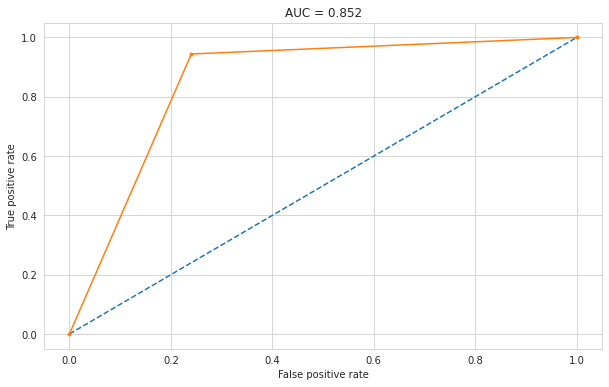

In [ ]:
# ROC curve and AUC 
probs = classifier.predict(X_test_scaled)
# keep probabilities for the positive outcome only
# probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

##Kernel SVM

Training the Kernel SVM model on the Training set

In [ ]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train_scaled, y_train)

SVC(random_state=0)

Making the Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tp, tn, fp, fn

(406, 440, 51, 97)

Calculating accuracy score

In [ ]:
accuracy_score_KernalSVM = accuracy_score(y_test, y_pred)
print(accuracy_score_KernalSVM)

0.8511066398390342


In [ ]:
#Cross Validation
cv_results = cross_val_score(classifier, X, y, cv=10) 

print (f"Cross-validated scores {cv_results}")
print(f"The Cross Validation accuracy is: {round(cv_results.mean() * 100,2)}%")

Cross-validated scores [0.84641638 0.84982935 0.84982935 0.84641638 0.84641638 0.84641638
 0.84982935 0.84931507 0.84589041 0.84931507]
The Cross Validation accuracy is: 84.8%


Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       491
           1       0.89      0.81      0.85       503

    accuracy                           0.85       994
   macro avg       0.85      0.85      0.85       994
weighted avg       0.85      0.85      0.85       994



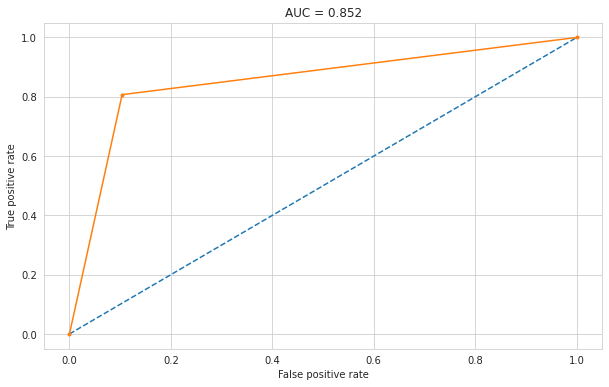

In [ ]:
# ROC curve and AUC 
probs = classifier.predict(X_test_scaled)
# keep probabilities for the positive outcome only
# probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

##Logistic Regression

In [ ]:
# the hashtag is used to represent "experimental coding as per almabetter classes"

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import cross_validate

In [ ]:
# logistic = LogisticRegression()

In [ ]:
# scoring = ['accuracy']
# scores = cross_validate(logistic,X_train, y_train, scoring = scoring , cv = 10, return_train_score=True,return_estimator=True,verbose = 10)

In [ ]:
# scores['train_accuracy']

In [ ]:
# scores['test_accuracy']

In [ ]:
# scores['estimator']

Training the Logistic Regression model on the Training set

In [ ]:
# search for optimun parameters using gridsearch
params = {'penalty':['l1','l2'],
         'C':[0.01,0.1,1,10,100],
         'class_weight':['balanced',None]}
classifier = GridSearchCV(LogisticRegression(),param_grid=params,cv=10)

In [ ]:
#train the classifier
classifier.fit(X_train_scaled,y_train)

classifier.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Sol

{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}

In [ ]:
#make predictions
y_pred = classifier.predict(X_test_scaled)

In [ ]:
# from sklearn.linear_model import LogisticRegression
# classifier = LogisticRegression(random_state = 0)
# classifier.fit(X_train_scaled, y_train)

In [ ]:
log_accuracy = accuracy_score(y_test,y_pred)
print(f"Using logistic regression we get an accuracy of {round(log_accuracy*100,2)}%")

Using logistic regression we get an accuracy of 70.93%


In [ ]:
#Cross Validation
cv_results = cross_val_score(classifier, X, y, cv=10) 

print (f"Cross-validated scores {cv_results}")
print(f"The Cross Validation accuracy is: {round(cv_results.mean() * 100,2)}%")

Streaming output truncated to the last 5000 lines.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:81

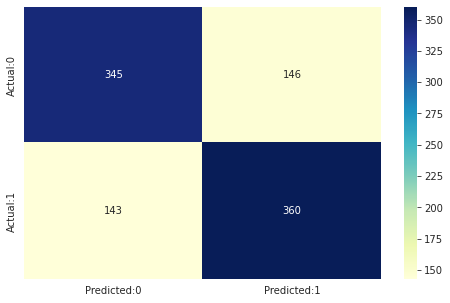

In [ ]:
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

Making the Confusion Matrix

In [ ]:
# from sklearn.metrics import confusion_matrix, accuracy_score
# y_pred = classifier.predict(X_test_scaled)
# tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# tp, tn, fp, fn

(357, 350, 141, 146)

Calculating accuracy score

In [ ]:
accuracy_score_LogisticRegression = accuracy_score(y_test, y_pred)
print(accuracy_score_LogisticRegression)

0.7112676056338029


Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71       491
           1       0.72      0.71      0.71       503

    accuracy                           0.71       994
   macro avg       0.71      0.71      0.71       994
weighted avg       0.71      0.71      0.71       994



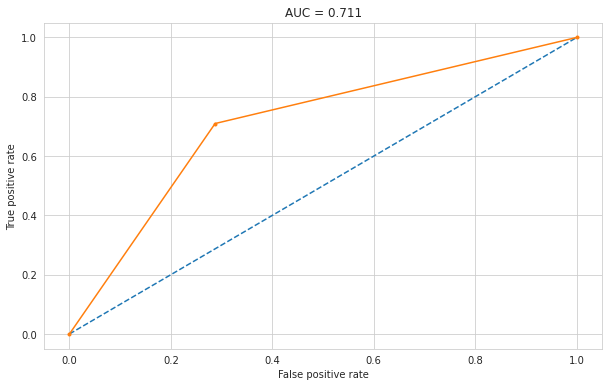

In [ ]:
# ROC curve and AUC 
probs = classifier.predict(X_test_scaled)
# keep probabilities for the positive outcome only
# probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

##Naive Bayes

Training the Naive Bayes model on the Training set

In [ ]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train_scaled, y_train)

GaussianNB()

Making the Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tp, tn, fp, fn

(230, 426, 65, 273)

Calculating accuracy score

In [ ]:
accuracy_score_NaiveBayes = accuracy_score(y_test, y_pred)
print(accuracy_score_NaiveBayes)

0.6599597585513078


In [ ]:
#Cross Validation
cv_results = cross_val_score(classifier, X, y, cv=10) 

print (f"Cross-validated scores {cv_results}")
print(f"The Cross Validation accuracy is: {round(cv_results.mean() * 100,2)}%")

Cross-validated scores [0.8225256  0.83276451 0.83959044 0.79522184 0.83959044 0.8225256
 0.83617747 0.81849315 0.82876712 0.81164384]
The Cross Validation accuracy is: 82.47%


Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.87      0.72       491
           1       0.78      0.46      0.58       503

    accuracy                           0.66       994
   macro avg       0.69      0.66      0.65       994
weighted avg       0.70      0.66      0.65       994



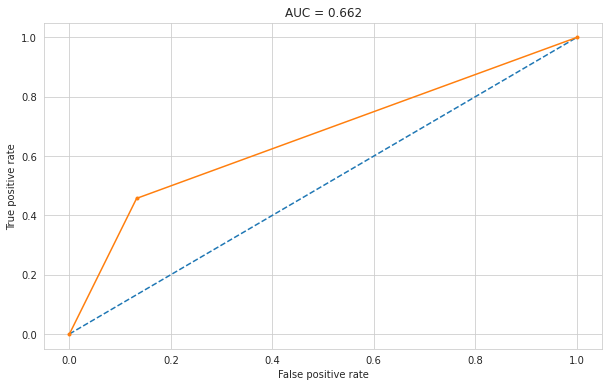

In [ ]:
# ROC curve and AUC 
probs = classifier.predict(X_test_scaled)
# keep probabilities for the positive outcome only
# probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

##Random Forest Classification

Training the Random Forest Classification model on the Training set

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train_scaled, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

Making the Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tp, tn, fp, fn

(420, 479, 12, 83)

Calculating accuracy score

In [ ]:
accuracy_score_RandomForest = accuracy_score(y_test, y_pred)
print(accuracy_score_RandomForest)

0.9044265593561368


In [ ]:
#Cross Validation
cv_results = cross_val_score(classifier, X, y, cv=10) 

print (f"Cross-validated scores {cv_results}")
print(f"The Cross Validation accuracy is: {round(cv_results.mean() * 100,2)}%")

Cross-validated scores [0.84641638 0.82935154 0.85324232 0.83276451 0.84641638 0.85665529
 0.82935154 0.8390411  0.83219178 0.84589041]
The Cross Validation accuracy is: 84.11%


Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       491
           1       0.97      0.83      0.90       503

    accuracy                           0.90       994
   macro avg       0.91      0.91      0.90       994
weighted avg       0.91      0.90      0.90       994



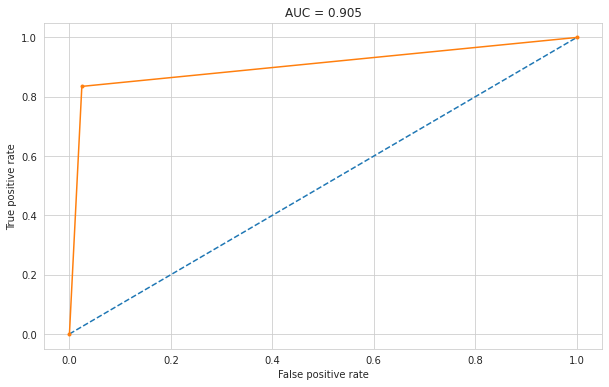

In [ ]:
# ROC curve and AUC 
probs = classifier.predict(X_test_scaled)
# keep probabilities for the positive outcome only
# probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

##Support Vector Machine (SVM)

Training the SVM model on the Training set

In [ ]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train_scaled, y_train)

SVC(kernel='linear', random_state=0)

Making the Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tp, tn, fp, fn

(370, 333, 158, 133)

Calculating accuracy score

In [ ]:
accuracy_score_SVM = accuracy_score(y_test, y_pred)
print(accuracy_score_SVM)

0.7072434607645876


In [ ]:
#Cross Validation
cv_results = cross_val_score(classifier, X, y, cv=10) 

print (f"Cross-validated scores {cv_results}")
print(f"The Cross Validation accuracy is: {round(cv_results.mean() * 100,2)}%")

Cross-validated scores [0.84982935 0.84982935 0.84982935 0.84641638 0.84641638 0.84641638
 0.84641638 0.84931507 0.84931507 0.84931507]
The Cross Validation accuracy is: 84.83%


Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.68      0.70       491
           1       0.70      0.74      0.72       503

    accuracy                           0.71       994
   macro avg       0.71      0.71      0.71       994
weighted avg       0.71      0.71      0.71       994



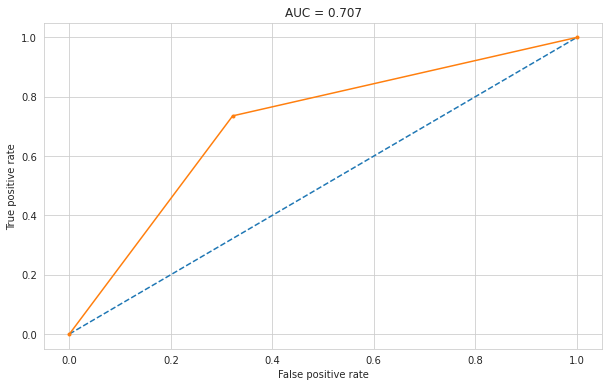

In [ ]:
# ROC curve and AUC 
probs = classifier.predict(X_test_scaled)
# keep probabilities for the positive outcome only
# probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

##XGB Classifier

Training XGBClassifier model on the Training set

In [ ]:
from xgboost import XGBClassifier
classifier = XGBClassifier(random_state=0)
classifier.fit(X_train_scaled, y_train)

XGBClassifier()

Making the Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tp, tn, fp, fn

(422, 485, 6, 81)

Calculating accuracy score

In [ ]:
accuracy_score_XGBClassifier = accuracy_score(y_test, y_pred)
print(accuracy_score_XGBClassifier)

0.9124748490945674


In [ ]:
#Cross Validation
cv_results = cross_val_score(classifier, X, y, cv=10) 

print (f"Cross-validated scores {cv_results}")
print(f"The Cross Validation accuracy is: {round(cv_results.mean() * 100,2)}%")

Cross-validated scores [0.84641638 0.85665529 0.85665529 0.84982935 0.84982935 0.84641638
 0.83617747 0.84246575 0.84589041 0.85273973]
The Cross Validation accuracy is: 84.83%


Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       491
           1       0.99      0.84      0.91       503

    accuracy                           0.91       994
   macro avg       0.92      0.91      0.91       994
weighted avg       0.92      0.91      0.91       994



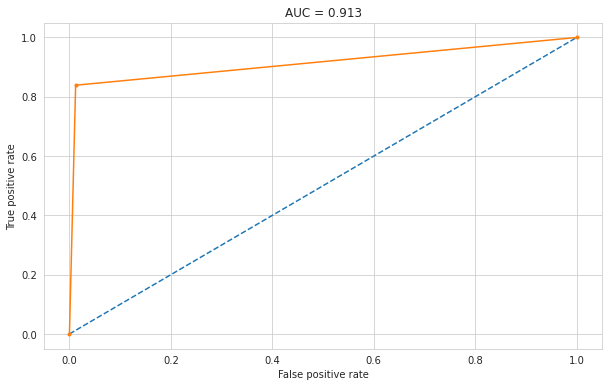

In [ ]:
# ROC curve and AUC 
probs = classifier.predict(X_test_scaled)
# keep probabilities for the positive outcome only
# probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

##CatBoost Classifier

Training the CatBoostClassifier model on the Training set

In [ ]:
from catboost import CatBoostClassifier
classifier = CatBoostClassifier()
classifier.fit(X_train, y_train)

Learning rate set to 0.018566
0:	learn: 0.6687854	total: 6.15ms	remaining: 6.15s
1:	learn: 0.6455314	total: 11ms	remaining: 5.48s
2:	learn: 0.6245363	total: 16.2ms	remaining: 5.4s
3:	learn: 0.6025934	total: 21.1ms	remaining: 5.26s
4:	learn: 0.5841153	total: 26.1ms	remaining: 5.18s
5:	learn: 0.5646381	total: 30.9ms	remaining: 5.11s
6:	learn: 0.5479762	total: 38.2ms	remaining: 5.41s
7:	learn: 0.5305588	total: 49.5ms	remaining: 6.13s
8:	learn: 0.5141327	total: 57.1ms	remaining: 6.29s
9:	learn: 0.4996802	total: 62ms	remaining: 6.14s
10:	learn: 0.4868325	total: 67.4ms	remaining: 6.06s
11:	learn: 0.4747921	total: 72.4ms	remaining: 5.96s
12:	learn: 0.4631723	total: 77.4ms	remaining: 5.88s
13:	learn: 0.4514826	total: 82.7ms	remaining: 5.82s
14:	learn: 0.4410314	total: 87.6ms	remaining: 5.75s
15:	learn: 0.4317965	total: 92.5ms	remaining: 5.69s
16:	learn: 0.4235223	total: 97.3ms	remaining: 5.63s
17:	learn: 0.4147225	total: 102ms	remaining: 5.58s
18:	learn: 0.4072776	total: 107ms	remaining: 5.54s

Making the Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tp, tn, fp, fn 

(422, 486, 5, 81)

Calculating accuracy score

In [ ]:
accuracy_score_CatBoost = accuracy_score(y_test, y_pred)
print(accuracy_score_CatBoost)

0.9134808853118712


In [ ]:
#Cross Validation
cv_results = cross_val_score(classifier, X, y, cv=10) 

print (f"Cross-validated scores {cv_results}")
print(f"The Cross Validation accuracy is: {round(cv_results.mean() * 100,2)}%")

Streaming output truncated to the last 5000 lines.
7:	learn: 0.6144755	total: 29.6ms	remaining: 3.67s
8:	learn: 0.6067516	total: 31.2ms	remaining: 3.44s
9:	learn: 0.5994559	total: 33.3ms	remaining: 3.29s
10:	learn: 0.5918361	total: 35.4ms	remaining: 3.18s
11:	learn: 0.5841728	total: 37.5ms	remaining: 3.09s
12:	learn: 0.5771342	total: 39.5ms	remaining: 3s
13:	learn: 0.5705636	total: 41.7ms	remaining: 2.93s
14:	learn: 0.5649686	total: 43.8ms	remaining: 2.88s
15:	learn: 0.5592282	total: 46ms	remaining: 2.83s
16:	learn: 0.5537110	total: 48.1ms	remaining: 2.78s
17:	learn: 0.5479466	total: 50.3ms	remaining: 2.74s
18:	learn: 0.5424247	total: 52.6ms	remaining: 2.72s
19:	learn: 0.5368921	total: 54.7ms	remaining: 2.68s
20:	learn: 0.5317086	total: 57.1ms	remaining: 2.66s
21:	learn: 0.5267350	total: 59.4ms	remaining: 2.64s
22:	learn: 0.5215863	total: 61.7ms	remaining: 2.62s
23:	learn: 0.5164938	total: 63.9ms	remaining: 2.6s
24:	learn: 0.5120620	total: 66.2ms	remaining: 2.58s
25:	learn: 0.5076312	t

Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       491
           1       0.99      0.84      0.91       503

    accuracy                           0.91       994
   macro avg       0.92      0.91      0.91       994
weighted avg       0.92      0.91      0.91       994



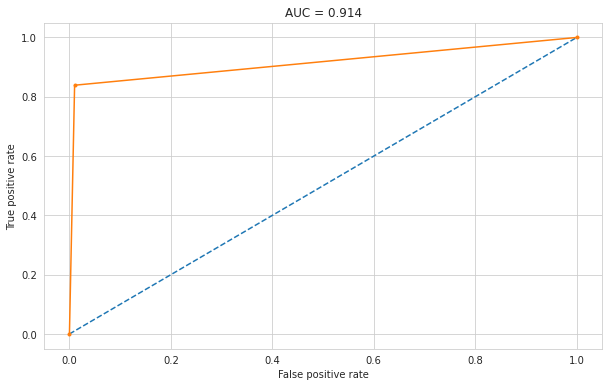

In [ ]:
# ROC curve and AUC 
probs = classifier.predict(X_test)
# keep probabilities for the positive outcome only
# probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

##Accuracy Scores of each classification model are as follows 

In [ ]:
print(f'''Accuracy Scores:

Decision Tree Classification: {accuracy_score_DecisionTree}
K Nearest Neigbours         : {accuracy_score_KNNClassifier}
Kernal SVM                  : {accuracy_score_KernalSVM}
Logistic Regression         : {accuracy_score_LogisticRegression}
Naive Bayes                 : {accuracy_score_NaiveBayes}
Random Forest Classification: {accuracy_score_RandomForest}
Support Vector Machine      : {accuracy_score_SVM}
XGB Classifier              : {accuracy_score_XGBClassifier}
CatBoost Classifier         : {accuracy_score_CatBoost}
''')

Accuracy Scores:

Decision Tree Classification: 0.8601609657947686
K Nearest Neigbours         : 0.8531187122736419
Kernal SVM                  : 0.8450704225352113
Logistic Regression         : 0.7173038229376257
Naive Bayes                 : 0.6670020120724346
Random Forest Classification: 0.9114688128772636
Support Vector Machine      : 0.7132796780684104
XGB Classifier              : 0.9144869215291751
CatBoost Classifier         : 0.9114688128772636



In [ ]:
'''
Accuracy Scores: Before Balancing data vs Balancing Data-SMOTE vs Balancing Data-MSMOTE

Decision Tree Classification: 0.7679180887372014
K Nearest Neigbours         : 0.8191126279863481
Kernal SVM                  : 0.8378839590443686
Logistic Regression         : 0.8395904436860068
Naive Bayes                 : 0.8088737201365188
Random Forest Classification: 0.8191126279863481
Support Vector Machine      : 0.8395904436860068
XGB Classifier              : 0.8327645051194539
CatBoost Classifier         : 0.8327645051194539



Decision Tree Classification: 0.831096196868009
K Nearest Neigbours         : 0.7975391498881432
Kernal SVM                  : 0.7684563758389261
Logistic Regression         : 0.6868008948545862
Naive Bayes                 : 0.6006711409395973
Random Forest Classification: 0.8713646532438478
Support Vector Machine      : 0.6767337807606264
XGB Classifier              : 0.8501118568232662
CatBoost Classifier         : 0.8747203579418344



Decision Tree Classification: 0.8601609657947686
K Nearest Neigbours         : 0.8531187122736419
Kernal SVM                  : 0.8450704225352113
Logistic Regression         : 0.7173038229376257
Naive Bayes                 : 0.6670020120724346
Random Forest Classification: 0.9114688128772636
Support Vector Machine      : 0.7132796780684104
XGB Classifier              : 0.9144869215291751
CatBoost Classifier         : 0.9114688128772636

'''

'\nAccuracy Scores: Before Balancing data vs Balancing Data-SMOTE vs Balancing Data-MSMOTE\n\nDecision Tree Classification: 0.7679180887372014\nK Nearest Neigbours         : 0.8191126279863481\nKernal SVM                  : 0.8378839590443686\nLogistic Regression         : 0.8395904436860068\nNaive Bayes                 : 0.8088737201365188\nRandom Forest Classification: 0.8191126279863481\nSupport Vector Machine      : 0.8395904436860068\nXGB Classifier              : 0.8327645051194539\nCatBoost Classifier         : 0.8327645051194539\n\n\n\nDecision Tree Classification: 0.831096196868009\nK Nearest Neigbours         : 0.7975391498881432\nKernal SVM                  : 0.7684563758389261\nLogistic Regression         : 0.6868008948545862\nNaive Bayes                 : 0.6006711409395973\nRandom Forest Classification: 0.8713646532438478\nSupport Vector Machine      : 0.6767337807606264\nXGB Classifier              : 0.8501118568232662\nCatBoost Classifier         : 0.8747203579418344\n\